# Force prediction error on all Kalman filtered field data

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
from phd.visualization.maps import plot_map, plot_trips, plot_missions, plot_tests
from phd.visualization.plot_prediction import plot_total_force,plot_force_components
import inspect
from sklearn.metrics import r2_score
from scipy.optimize import least_squares
import statsmodels.api as sm

import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
#plt.style.use('bmh')
#plt.rcParams['figure.figsize'] = 12, 15


In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ ship }.time_series")
time_series_filtered = catalog.load(f"{ ship }.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
model_loaders = catalog.load(f"{ship}.models")
units = catalog.load(f"{ship}.units")

[07/10/23 17:18:59] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=253409;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=96684;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/10/23 17:19:08] INFO     Kedro project phd                                                      ]8;id=993236;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=794255;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=26320;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=44859;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=923104;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=509406;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.time_series' (PartitionedDataSet)...         ]8;id=959739;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=840401;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.time_series_preprocessed.ek_smooth'          ]8;id=222460;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=464227;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=994788;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=700453;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=798691;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=326277;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=387339;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=113022;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=50080;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=239705;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=871539;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=10074;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
model = model_loaders['VCT_MDL_resistance']()

In [6]:
data = time_series['motoring_7m_all_data']()

In [7]:
data_filtered = time_series_filtered['motoring_7m_all_data']()

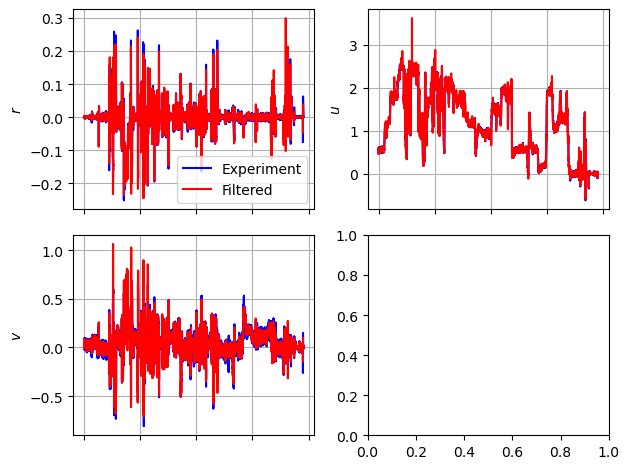

In [8]:
dataframes = {
'Experiment':data.select_dtypes(exclude='object').rolling(window=10).mean(),
'Filtered':data_filtered,
}
plot(dataframes, keys=['u','v','r']);

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

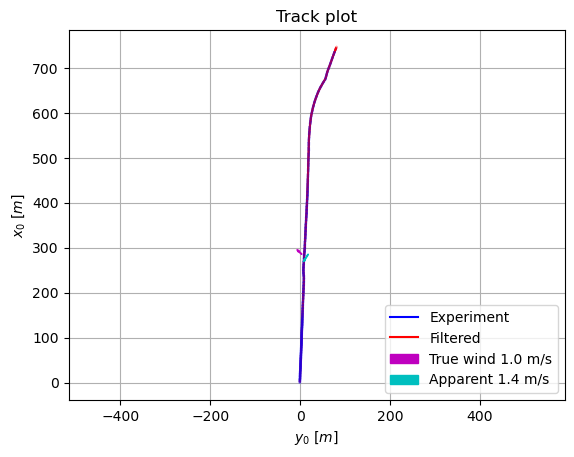

In [9]:
dataframes = {
    'Experiment': data.loc[0:700],
    'Filtered' : data_filtered.loc[0:700],
}

track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'])

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

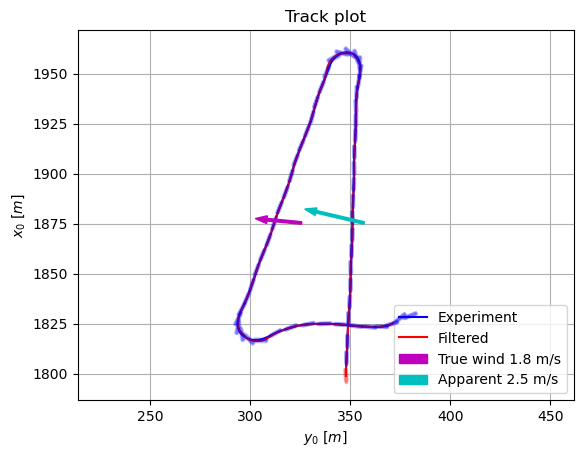

In [10]:
start = 1300
stop = 1500
dataframes = {
    'Experiment': data.loc[start:stop],
    'Filtered' : data_filtered.loc[start:stop],
}

track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'])

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

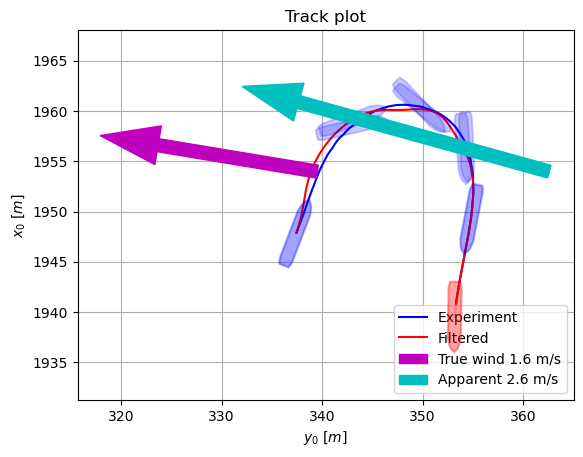

In [11]:
start = 1410
stop = 1440
dataframes = {
    'Experiment': data.loc[start:stop],
    'Filtered' : data_filtered.loc[start:stop],
}

track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'])

In [12]:
df_forces_predicted = pd.DataFrame(model.calculate_forces(states_dict=data_filtered[model.states_str], control=data_filtered[model.control_keys]))
df_forces_predicted['fx'] = df_forces_predicted['X_D']
df_forces_predicted['fy'] = df_forces_predicted['Y_D']
df_forces_predicted['mz'] = df_forces_predicted['N_D']


In [13]:
df_forces_predicted.head()

,X_H,Y_H,N_H,thrust,X_P,V_x,C_L,X_R,Y_R,N_R,X_D,Y_D,N_D,fx,fy,mz
time(us),,,,,,,,,,,,,,,,
0.000000,-5.268144,0.380263,2.460957,8.854312,7.818357,0.660485,-0.003064,-0.031978,-0.053292,0.177276,2.518235,0.326971,2.638233,2.518235,0.326971,2.638233
0.199987,-5.278001,0.375703,2.416672,8.845805,7.810846,0.660452,-0.010710,-0.032412,-0.186230,0.619493,2.500433,0.189472,3.036165,2.500433,0.189472,3.036165
0.400023,-5.313570,0.365829,2.342869,8.815920,7.784457,0.660336,-0.010781,-0.032408,-0.187410,0.623418,2.438479,0.178419,2.966287,2.438479,0.178419,2.966287
0.599958,-5.364890,0.343050,2.203150,8.772848,7.746425,0.660174,-0.011098,-0.032422,-0.192819,0.641408,2.349112,0.150231,2.844559,2.349112,0.150231,2.844559
0.800069,-5.425293,0.299885,1.956364,8.722063,7.701582,0.659990,-0.011783,-0.032470,-0.204599,0.680595,2.243819,0.095286,2.636959,2.243819,0.095286,2.636959


In [14]:
df_forces = model.forces_from_motions(data=data_filtered)

In [15]:
df_forces.head()

,x0,y0,psi,u,v,r,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,mission,date,delta,phi,y_GPS,x_GPS,u1d,v1d,r1d,aws,awa,V,U,beta,tws,twa,rev,fx,fy,mz
time(us),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,2.794818,-0.520842,6.275450,0.459886,-0.009565,-0.000941,6.2749,-0.028531,0.5219,0.3838,0.2322,59.279236,18.318385,0.0087,3.0003,1.4838,2.9773,1.9999,2.7980,1.6423,2.8205,2.1337,20.0,0.0,0.0052,0.0165,0.0109,-0.0006,0.0412,-0.1080,-9.8133,2.9574,1.7029,2.8695,2.2150,2.7732,1.7491,2.2361,"Mission started at: 2021/4/29,9:22:58,command ...",2021-04-28 09:59:07.245075,-0.004053,0.0087,0.000000,0.000000,0.002666,0.000589,0.000228,1.72600,2.86530,0.459986,0.459986,0.020795,2.174164,2.911059,3.9714,2.985356,0.812074,1.392491
0.199987,2.887098,-0.523472,6.275261,0.460420,-0.009447,-0.000895,6.2754,-0.028440,0.5305,0.5050,0.4644,59.279237,18.318385,0.0139,2.9985,1.5056,2.9758,2.0216,2.7949,1.6504,2.8181,2.1413,20.0,0.0,0.0071,0.0344,0.0056,0.0009,0.0789,-0.1363,-9.9561,2.9707,1.7646,2.8932,2.2781,2.7576,1.7491,2.2329,NaN,2021-04-28 09:59:07.445062,-0.008105,0.0139,-0.000706,0.099428,0.006012,0.000975,0.000243,1.75685,2.86415,0.460516,0.460516,0.020516,2.205357,2.909313,3.9714,6.745953,1.695538,1.386704
0.400023,2.979484,-0.526100,6.275081,0.462292,-0.009175,-0.000844,6.2758,-0.027948,0.5344,0.4864,0.4644,59.279238,18.318385,0.0203,3.0003,1.5283,2.9764,2.0448,2.7920,1.6580,2.8152,2.1486,20.0,0.0,0.0074,0.0319,-0.0025,-0.0001,0.0691,-0.1952,-9.9039,3.0213,1.8006,2.9712,2.3241,2.7576,1.7491,2.2369,NaN,2021-04-28 09:59:07.645098,-0.008105,0.0203,0.000710,0.187044,0.011423,0.002182,0.000247,1.77485,2.88945,0.462383,0.462383,0.019844,2.227358,2.929155,3.9714,12.825976,4.413042,1.138493
0.599958,3.072247,-0.528693,6.274912,0.464988,-0.008574,-0.000796,6.2753,-0.026711,0.5378,0.4684,0.4644,59.279239,18.318385,0.0245,3.0044,1.5488,2.9780,2.0663,2.7894,1.6649,2.8117,2.1553,20.0,0.0,0.0068,0.0107,-0.0033,-0.0012,0.0588,-0.1961,-9.8416,3.0475,1.8006,2.8103,2.3277,2.7576,1.7491,2.2369,NaN,2021-04-28 09:59:07.845033,-0.008105,0.0245,-0.000123,0.295859,0.014677,0.004258,0.000228,1.77485,2.90255,0.465067,0.465067,0.018438,2.230969,2.939908,3.9714,16.482763,9.062278,0.565828
0.800069,3.165551,-0.531183,6.274752,0.468164,-0.007471,-0.000752,6.2747,-0.024390,0.5238,0.5080,0.4644,59.279240,18.318385,0.0246,3.0082,1.5622,2.9796,2.0806,2.7851,1.6684,2.8072,2.1584,20.0,0.0,0.0062,-0.0087,-0.0043,-0.0010,0.0571,-0.2200,-9.8506,3.0543,1.7434,2.8575,2.2733,2.7381,1.7204,2.2062,NaN,2021-04-28 09:59:08.045144,-0.008105,0.0246,-0.005129,0.400005,0.016617,0.007061,0.000209,1.73190,2.89620,0.468223,0.468223,0.015957,2.190443,2.936400,3.9714,18.663888,15.330780,-0.173068


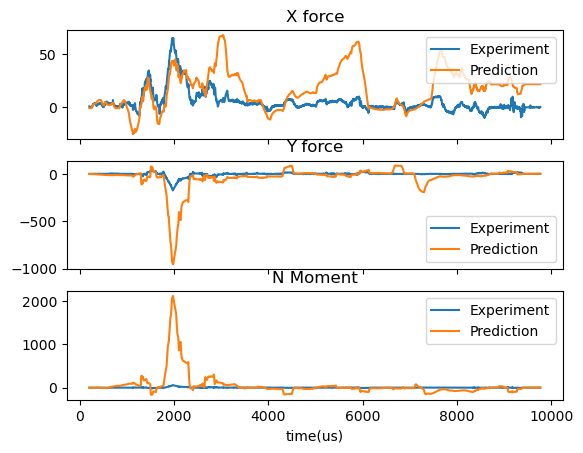

In [16]:
plot_total_force(model=model, data=data_filtered, window=1000);

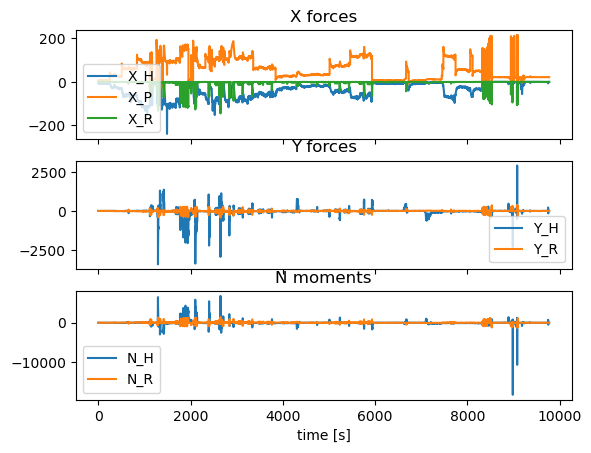

In [17]:
plot_force_components(model=model, data=data_filtered);

In [18]:
t_start = (df_forces['fy'].abs() > 2000).idxmax()

In [19]:
t_start

2648.367548

In [20]:
t_pad_before = 10
t_pad_after = 20

df_sample = df_forces.loc[t_start-t_pad_before:t_start+t_pad_after].copy()

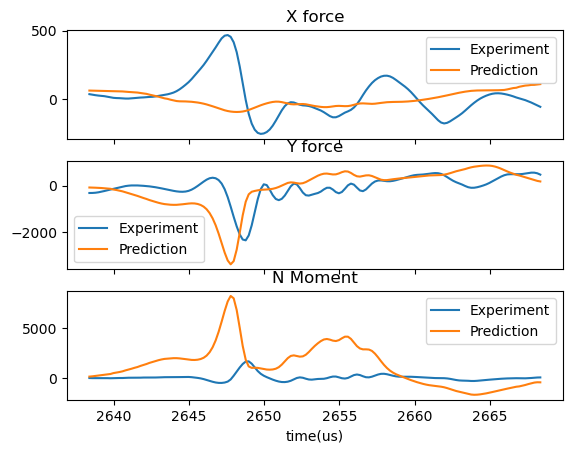

In [21]:
plot_total_force(model=model, data=df_sample);

In [22]:
beta_ = smallest_signed_angle(data_filtered['beta'])
R_crit=50
mask = ((beta_.abs() < np.deg2rad(0.5)) & 
        (data_filtered['r'].abs() < (data_filtered['u'].mean() / (R_crit*ship_data['L']))) &
        (data_filtered['tws'].abs() < 2) &
        (data_filtered.index < 670)
        
        )
df_straight = df_forces.loc[mask]

<Axes: xlabel='time(us)'>

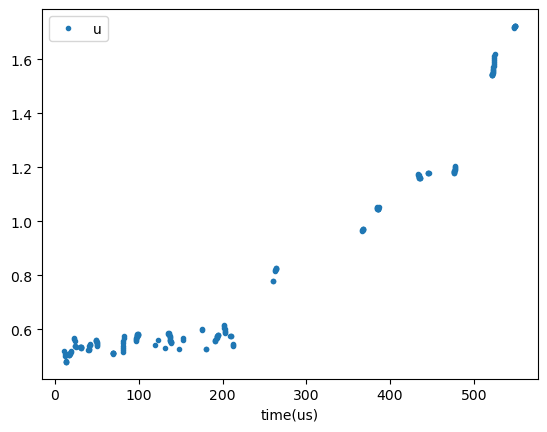

In [23]:
df_straight.loc[mask].plot(y='u', style='.')

In [24]:
groups = df_straight.groupby(by='thrusterTarget')
df_straight = groups.filter(lambda x : len(x) > 10)
df_straight['thrusterTarget'].unique()

array([20., 40., 60.])

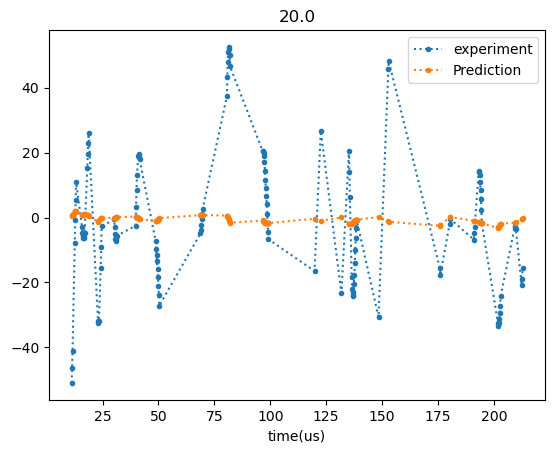

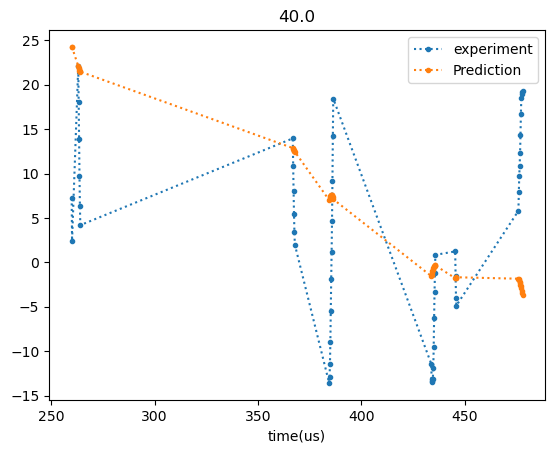

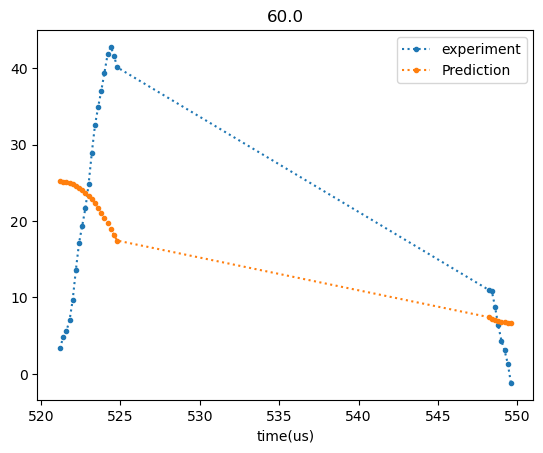

In [25]:
groups = df_straight.groupby(by='thrusterTarget')

for thrusterTarget,group in groups:
    fig,ax=plt.subplots()
    group.plot(y='fx', style='.:', label='experiment', ax=ax)
    df_forces_predicted.loc[group.index].plot(y='fx', style='.:', label='Prediction', ax=ax)
    ax.set_title(thrusterTarget)
    


<Axes: xlabel='time(us)'>

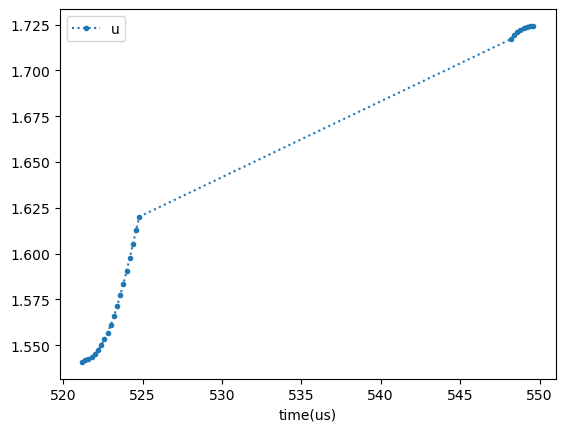

In [26]:
groups.get_group(60).plot(y='u', style='.:')

In [27]:
def calculate_fx(data, rev):
    
    control = data[model.control_keys]
    states = data[['x0','y0','psi','u','v','r']]
    control['rev'] = rev
    df_force_predicted = pd.DataFrame(model.calculate_forces(states_dict=states, control=control))
    df_force_predicted['fx'] = run(model.lambda_X_D, inputs=df_force_predicted)
    return df_force_predicted
    

def predict_fx_rev(x, data:pd.DataFrame, df_force:pd.DataFrame):
    
    df_force_predicted = calculate_fx(data=data, rev=x[0])
    
    residual = (df_force['fx'] - df_force_predicted['fx'])
    return residual

def fit_rev(data:pd.DataFrame):
    
    df_force = model.forces_from_motions(data=data)
    
    kwargs = {
        'data':data,
        'df_force':df_force
    }
    
    return least_squares(fun=predict_fx_rev, x0=[3.0], bounds=(0, np.inf), kwargs=kwargs)
    

In [38]:
model.parameters

{'C0_w_p0': 0.10378571428571445,
 'C1_w_p0': 0.24690520231438584,
 'k_0': 0.576581716472807,
 'k_1': -0.3683675998138215,
 'k_2': -0.07542975438913463,
 'g': 9.81,
 'C_L_tune': 1.0,
 'delta_lim': 1.3962634015954636,
 'kappa': 0.25,
 'nu': 1.18849e-06,
 'Xthrust': 0.883,
 'Xudot': 0.00017880704448812042,
 'Yvdot': -0.006109387408263365,
 'Yrdot': -0.00030313777458141895,
 'Nvdot': -0.00012825440172375716,
 'Nrdot': -0.00029867482773178765,
 'X0': -0.0010351242520552366,
 'Xu': 0.00035129440952440743,
 'Xvv': -0.0013391376150706925,
 'Yvvv': -0.12641371651391264,
 'Yv': -0.003372666554617324,
 'Nvvv': -0.024604169399312037,
 'Nv': -0.0025966465494148064,
 'Xrr': -0.00035470521519139663,
 'Nrrr': -0.002572123992950829,
 'Nr': -0.0008006896191474081,
 'Xvr': -0.0029936162915255022,
 'Yvrr': -0.06995629388360704,
 'Nvvr': -0.07745931644358173,
 'Nvrr': -0.039241834077471484,
 'Yvvr': -0.13386362536088584,
 'Yvr': 0.012643658914673636,
 'Nvr': 0.007408390470059401}

In [28]:
Pd_to_rev = groups.apply(func=lambda x: fit_rev(x).x[0])
Pd_to_rev

thrusterTarget
20.0     3.880708
40.0     7.879895
60.0    12.325941
dtype: float64

In [29]:
X = pd.DataFrame(index=Pd_to_rev.index)
X['thrusterTarget'] = Pd_to_rev.index
X['const'] = 1
y = Pd_to_rev
Pd_model = sm.OLS(y,X)
Pd_model_fit = Pd_model.fit()

In [30]:
Pd_model_fit.summary()

[07/10/23 17:19:41] WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/statsmodels/ ]8;id=44820;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=905196;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             stats/stattools.py:74: ValueWarning: omni_normtest is not valid with                  
                             less than 8 observations; 3 samples were given.                                       
                               warn("omni_normtest is not valid with less than 8 observations; %i "                
                                                                                                                   

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1072.
Date:                Mon, 10 Jul 2023   Prob (F-statistic):             0.0194
Time:                        17:19:41   Log-Likelihood:                 2.4953
No. Observations:                   3   AIC:                           -0.9906
Df Residuals:                       1   BIC:                            -2.793
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
thrusterTarget     0.2111      0.006     32.734      0.019       0.129       0.293
const             -0.4164      0.279     -1.494      0.375      -3.957       3.124
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                          -0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='thrusterTarget'>

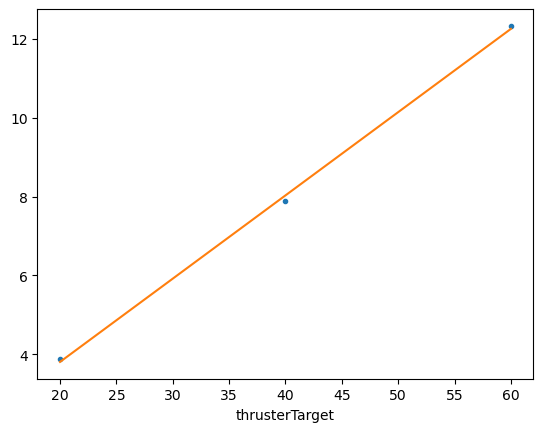

In [31]:
fig,ax=plt.subplots()
Pd_to_rev.plot(style='.', ax=ax)
Pd_model_fit.predict(X).plot(ax=ax)

In [32]:
data_filtered['thrusterTarget'] = data_filtered['thrusterTarget'].fillna(method='ffill')
X = data_filtered[['thrusterTarget']]
X['const'] = 1
data_filtered['rev'] = Pd_model_fit.predict(X)
#mask = data_filtered["rev"] < 0
#data_filtered.loc[mask, "rev"] = np.NaN
#data_filtered["rev"] = data_filtered["rev"].fillna(method='ffill')

<Axes: xlabel='time(us)'>

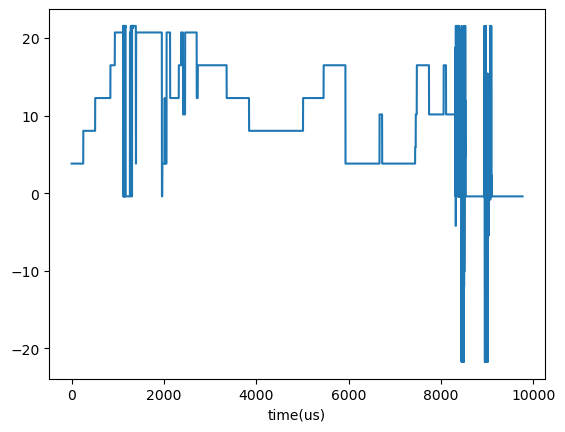

In [33]:
data_filtered['rev'].plot()

In [34]:
df_forces_predicted = pd.DataFrame(model.calculate_forces(states_dict=data_filtered[model.states_str], control=data_filtered[model.control_keys]))
df_forces_predicted['fx'] = df_forces_predicted['X_D']
df_forces_predicted['fy'] = df_forces_predicted['Y_D']
df_forces_predicted['mz'] = df_forces_predicted['N_D']

<Axes: xlabel='time(us)'>

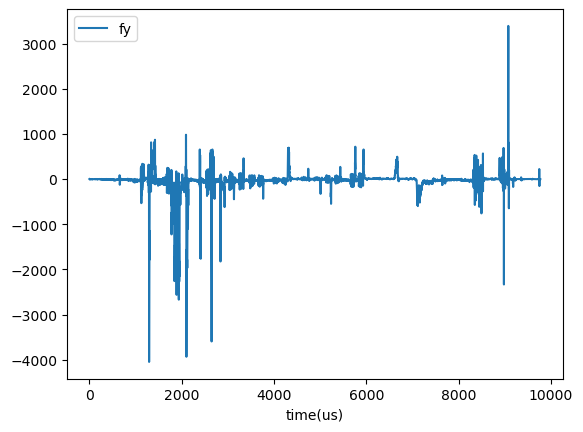

In [35]:
df_forces_predicted.plot(y='fy')

<Axes: xlabel='time(us)'>

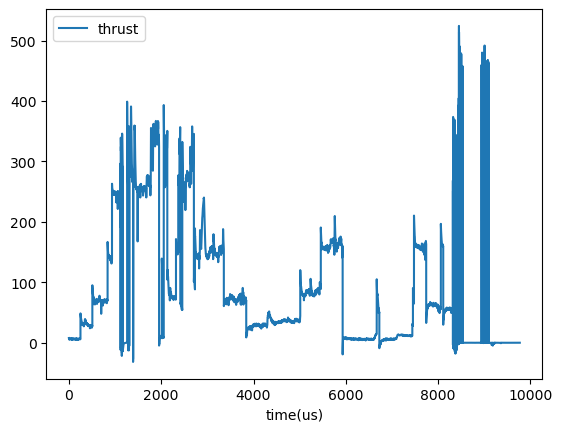

In [36]:
df_forces_predicted[['thrust']].plot()

In [37]:
data['thrusterTarget'].value_counts()

thrusterTarget
 20.0     8946
 80.0     7781
 60.0     7359
 40.0     7130
 0.0      7072
 100.0    5624
 50.0     3256
 104.0     798
 103.0      73
 30.0       66
-101.0      65
 49.0       27
 48.0       17
 101.0      13
 55.0       13
 88.0       10
 92.0       10
 102.0       9
 41.0        9
 99.0        9
 3.0         8
 89.0        8
 69.0        8
 42.0        8
 59.0        8
 68.0        8
 67.0        8
 91.0        8
 87.0        8
 27.0        8
 18.0        6
 72.0        6
 58.0        6
 38.0        6
 36.0        6
 71.0        5
 70.0        5
 57.0        5
 79.0        5
 64.0        5
 73.0        5
 90.0        5
 10.0        5
 26.0        5
 52.0        5
 39.0        5
 51.0        5
 23.0        5
 19.0        5
 43.0        5
 66.0        5
 95.0        5
 97.0        4
 85.0        4
 35.0        4
 31.0        4
 28.0        4
 34.0        4
 13.0        4
 46.0        4
 2.0         4
 61.0        4
 62.0        4
 47.0        4
 22.0        3
 32.0     